<div style="background: linear-gradient(135deg, #11998e, #38ef7d); 
            padding: 28px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            text-align:center; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.35);">

  <h1 style="margin:0; font-size:30px;">🔎 Notebook 2: Feature Extraction</h1>
  <h3 style="margin:10px 0 20px 0; font-weight:normal; font-size:18px;">
    Time-domain → Frequency-domain → Spectral Features
  </h3>

  <hr style="border: 1px solid rgba(255,255,255,0.4); width:60%; margin:auto;">

  <p style="margin-top:20px; font-size:16px; line-height:1.6;">
    <b>Author:</b> Engr. <span style="color:#FFD700;">Misha Urooj Khan</span><br>
    <b>Date:</b> 21-08-2025
  </p>
</div>


<div style="background: linear-gradient(135deg, #8360c3, #2ebf91); 
            padding: 20px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.3);">

  <h2 style="margin-top:0; text-align:center; font-size:24px;">✨ Feature Extraction Pipeline</h2>

  <p style="font-size:15px; line-height:1.6;">
    In this block, we move beyond preprocessing and actually <b>extract numerical features</b> 
    from each lung sound frame. These features capture the <b>spectral fingerprint</b> of breathing sounds 
    and will be crucial for classification tasks later.
  </p>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <h3 style="margin-bottom:6px;">📌 Steps Performed</h3>
  <ul style="font-size:14px; line-height:1.6;">
    <li>🎚️ <b>Preprocess</b>: normalize, band-pass filter, segment, and remove silent frames</li>
    <li>🔎 <b>Extract Features</b> from each frame:
      <ul>
        <li><b>SCN</b>: Spectral Centroid</li>
        <li><b>SCR</b>: Spectral Crest</li>
        <li><b>SDC</b>: Spectral Decrease</li>
        <li><b>SEN</b>: Spectral Entropy</li>
        <li><b>SFL</b>: Spectral Flatness</li>
        <li><b>SFLUX</b>: Spectral Flux</li>
        <li><b>SRO</b>: Spectral Roll-off</li>
        <li><b>SSL</b>: Spectral Slope</li>
        <li><b>SSP</b>: Spectral Spread</li>
      </ul>
    </li>
    <li>📊 <b>Organize results</b> in a Pandas DataFrame (rows = frames, cols = features)</li>
    <li>💾 <b>Save results</b> into an Excel file (<code>lung_sound_features.xlsx</code>) for later analysis</li>
  </ul>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <p style="font-size:14px; line-height:1.6;">
    ✅ This gives us a structured dataset where every lung sound frame is represented as a 
    <b>feature vector</b>. We can now analyze patterns, visualize feature spaces, 
    and train machine learning models for classification.
  </p>
</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, sosfiltfilt
from tqdm import tqdm

# -----------------------------
# PARAMETERS
# -----------------------------
DATA_ROOT = Path("/kaggle/input/spectral-paper/Dataset")
CLASS_NAMES = ["Normal", "Asthama", "Pneumonia"]

FS_TARGET = 44100
BANDPASS = (250, 2000)
FILTER_ORDER = 10
FRAME_MS = 250
HOP_RATIO = 0.5
SILENCE_PERCENTILE = 20

# -----------------------------
# SIGNAL HELPERS (from previous steps)
# -----------------------------
def read_wav(path):
    from scipy.io import wavfile
    fs, sig = wavfile.read(str(path))
    if np.issubdtype(sig.dtype, np.integer):
        sig = sig.astype(np.float32) / np.iinfo(sig.dtype).max
    else:
        sig = sig.astype(np.float32)
    if sig.ndim == 2:
        sig = sig.mean(axis=1)
    return fs, sig

def minmax_normalize(x, eps=1e-12):
    return (x - np.min(x)) / max(np.ptp(x), eps)

def frame_signal(x, fs, frame_ms=250, hop_ratio=0.5):
    frame_len = int(round(frame_ms * 1e-3 * fs))
    hop = int(round(frame_len * hop_ratio))
    n_frames = 1 + (len(x) - frame_len) // hop
    frames = np.lib.stride_tricks.as_strided(
        x,
        shape=(n_frames, frame_len),
        strides=(x.strides[0]*hop, x.strides[0]),
        writeable=False
    )
    return frames.copy()

def short_time_energy(frames): return (frames**2).mean(axis=1)

def drop_silent_frames(frames, percentile=20):
    energy = short_time_energy(frames)
    thr = np.percentile(energy, percentile)
    return frames[energy > thr]

def design_bandpass(fs, f_lo, f_hi, order=10):
    return butter(order, [f_lo, f_hi], btype="bandpass", fs=fs, output="sos")

def apply_zero_phase(sos, x): return sosfiltfilt(sos, x)

# -----------------------------
# FEATURE EXTRACTION FUNCTIONS
# -----------------------------
def spectral_features(frame, fs):
    """
    Compute spectral features from one frame.
    """
    N = len(frame)
    X = np.abs(rfft(frame))
    F = rfftfreq(N, 1/fs)

    # Avoid division by zero
    eps = 1e-12
    X = X + eps

    BE1, BE2 = 0, len(X)-1
    k = np.arange(BE1, BE2+1)

    # 1. Spectral Centroid
    SCN = np.sum(F * X) / np.sum(X)

    # 2. Spectral Crest
    SCR = np.max(X) / (np.mean(X))

    # 3. Spectral Decrease
    SDC = np.sum((X[1:] - X[0]) / np.arange(1, len(X))) / np.sum(X)

    # 4. Spectral Entropy
    P = X / np.sum(X)
    SEN = -np.sum(P * np.log2(P))

    # 5. Spectral Flatness
    SFL = (np.exp(np.mean(np.log(X)))) / (np.mean(X))

    # 6. Spectral Flux
    # Here we approximate with diff between consecutive bins
    SFLUX = np.sum(np.diff(X)**2) / len(X)

    # 7. Spectral Roll-off (85%)
    total_energy = np.sum(X)
    threshold = 0.85 * total_energy
    cumsum = np.cumsum(X)
    SRO = F[np.where(cumsum >= threshold)[0][0]]

    # 8. Spectral Slope (linear regression of spectrum)
    coeffs = np.polyfit(F, X, 1)
    SSL = coeffs[0]

    # 9. Spectral Spread
    mu = SCN
    SSP = np.sqrt(np.sum(((F - mu)**2) * X) / np.sum(X))

    return dict(SCN=SCN, SCR=SCR, SDC=SDC, SEN=SEN, 
                SFL=SFL, SFLUX=SFLUX, SRO=SRO, SSL=SSL, SSP=SSP)

# -----------------------------
# PIPELINE
# -----------------------------
all_features = []

sos = design_bandpass(FS_TARGET, *BANDPASS, FILTER_ORDER)

for cname in CLASS_NAMES:
    wavs = list((DATA_ROOT / cname).glob("*.wav"))
    for w in tqdm(wavs, desc=f"Processing {cname}"):
        fs, x = read_wav(w)
        x = x - x.mean()
        x = apply_zero_phase(sos, x)
        x = minmax_normalize(x)
        frames = frame_signal(x, fs, FRAME_MS, HOP_RATIO)
        frames = drop_silent_frames(frames, SILENCE_PERCENTILE)
        for f in frames:
            feats = spectral_features(f, fs)
            feats["Class"] = cname
            feats["File"] = w.name
            all_features.append(feats)

# -----------------------------
# SAVE & DISPLAY
# -----------------------------
df = pd.DataFrame(all_features)
display(df.head())



Processing Pneumonia: 100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


,SCN,SCR,SDC,SEN,SFL,SFLUX,SRO,SSL,SSP,Class,File
0,73.214053,5273.627225,-8.792561,0.664069,0.005950,5307.353795,0.0,-0.000277,719.598897,Normal,Normal (6).wav
1,96.031431,5005.386601,-8.344603,1.200558,0.007299,5307.464384,0.0,-0.000291,787.559653,Normal,Normal (6).wav
2,73.900920,4737.246199,-7.896994,1.631871,0.000606,5306.882702,0.0,-0.000309,282.572929,Normal,Normal (6).wav
3,107.803252,4551.711800,-7.587126,1.993468,0.004178,5306.064198,272.0,-0.000320,582.878529,Normal,Normal (6).wav
4,90.566753,4722.274339,-7.872143,1.669790,0.003360,5307.800948,0.0,-0.000309,534.973987,Normal,Normal (6).wav


In [2]:
# Save to Excel
df.to_excel("/kaggle/working/lung_sound_features.xlsx", index=False)
print("Saved features to lung_sound_features.xlsx")

Saved features to lung_sound_features.xlsx


<div style="background: linear-gradient(135deg, #ff9966, #ff5e62); 
            padding: 20px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.35);">

  <h2 style="margin-top:0; text-align:center; font-size:24px;">📊 Visualizing Feature Relationships</h2>

  <p style="font-size:15px; line-height:1.6;">
    After extracting features, we can <b>visualize them in pairs</b> to see how different lung sound classes 
    separate in the feature space. These scatter plots help us check whether our features are 
    <i>useful for classification</i>.
  </p>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <h3 style="margin-bottom:6px;">📌 Plots Explained</h3>
  <ul style="font-size:14px; line-height:1.6;">
    <li>🔵 <b>SCN vs SCR</b>: 
        - <b>Spectral Centroid (SCN)</b> measures the “center of mass” of the spectrum.<br>
        - <b>Spectral Crest (SCR)</b> measures the sharpness or peaky-ness of the spectrum.<br>
        👉 Together, they show how <i>normal, asthma, and pneumonia</i> sounds differ in frequency concentration vs sharpness.</li>
    <li>🟠 <b>SCN vs SEN</b>: 
        - <b>Spectral Centroid</b> again on the X-axis.<br>
        - <b>Spectral Entropy (SEN)</b> measures disorder/complexity of the spectrum.<br>
        👉 This plot reveals how <i>irregular vs smooth spectral distributions</i> can help separate conditions.</li>
  </ul>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <p style="font-size:14px; line-height:1.6;">
    ✅ If points from different classes cluster in different regions, 
    it means our features are <b>discriminative</b> and 
    will likely improve the performance of machine learning classifiers.
  </p>
</div>


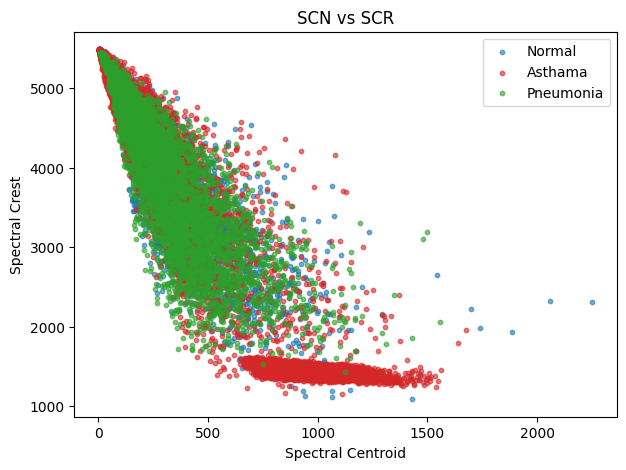

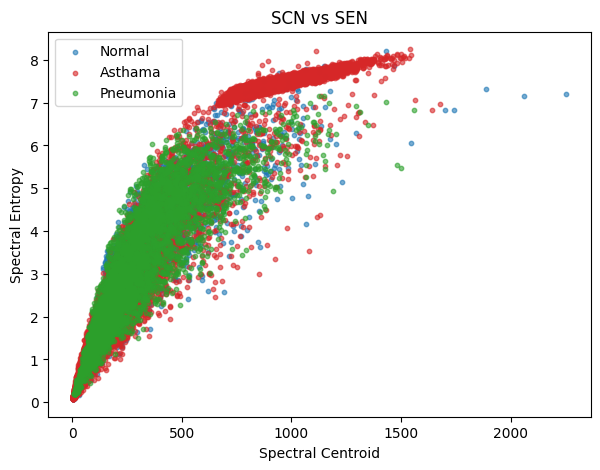

In [3]:
# Scatter: Spectral Centroid vs Spectral Crest
plt.figure(figsize=(7,5))
for cname, color in zip(CLASS_NAMES, ["#1f77b4","#d62728","#2ca02c"]):
    subset = df[df["Class"] == cname]
    plt.scatter(subset["SCN"], subset["SCR"], s=10, alpha=0.6, label=cname, color=color)
plt.xlabel("Spectral Centroid")
plt.ylabel("Spectral Crest")
plt.title("SCN vs SCR")
plt.legend()
plt.show()

# Scatter: Spectral Centroid vs Entropy
plt.figure(figsize=(7,5))
for cname, color in zip(CLASS_NAMES, ["#1f77b4","#d62728","#2ca02c"]):
    subset = df[df["Class"] == cname]
    plt.scatter(subset["SCN"], subset["SEN"], s=10, alpha=0.6, label=cname, color=color)
plt.xlabel("Spectral Centroid")
plt.ylabel("Spectral Entropy")
plt.title("SCN vs SEN")
plt.legend()
plt.show()


<div style="background: linear-gradient(135deg, #00c6ff, #0072ff); 
            padding: 20px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.35);">

  <h2 style="margin-top:0; text-align:center; font-size:24px;">📊 Scatter Plots: Flux & Roll-off vs Spectral Centroid</h2>

  <p style="font-size:15px; line-height:1.6;">
    These plots help us understand how <b>Spectral Centroid (SCN)</b> relates to other 
    spectral descriptors. If points from different classes cluster separately, it indicates 
    that these features are <b>good discriminators</b> for classification.
  </p>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <h3 style="margin-bottom:6px;">📌 Plots Explained</h3>
  <ul style="font-size:14px; line-height:1.6;">
    <li>⚡ <b>SCN vs Spectral Flux (SFLUX)</b>:  
        - Flux measures how much the spectrum changes between frequency bins.  
        - High flux = more variability (irregular breathing sounds).  
        👉 Useful for detecting <i>noisy or wheezy</i> signals.</li>
    <li>🎚️ <b>SCN vs Spectral Roll-off (SRO)</b>:  
        - Roll-off is the frequency below which 85% of the spectral energy lies.  
        - It indicates how “bright” or “sharp” a sound is.  
        👉 Helpful for distinguishing <i>Normal vs Asthma/Pneumonia</i> since 
        pathological sounds often shift spectral energy.</li>
  </ul>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <p style="font-size:14px; line-height:1.6;">
    ✅ Together with earlier plots (SCN vs SCR, SCN vs SEN), 
    these visualizations show how combining multiple spectral features 
    provides a richer separation of lung sound classes.
  </p>
</div>


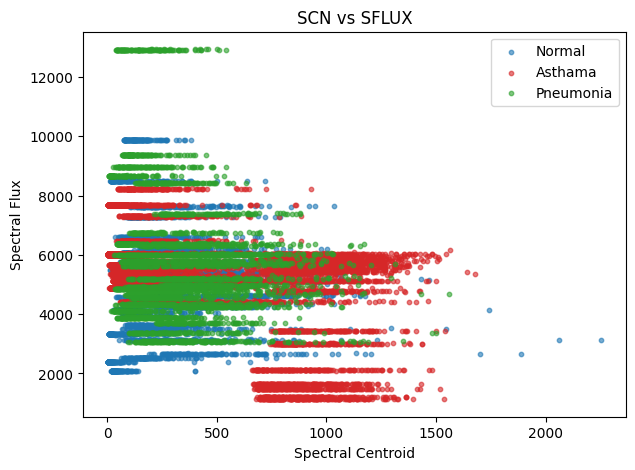

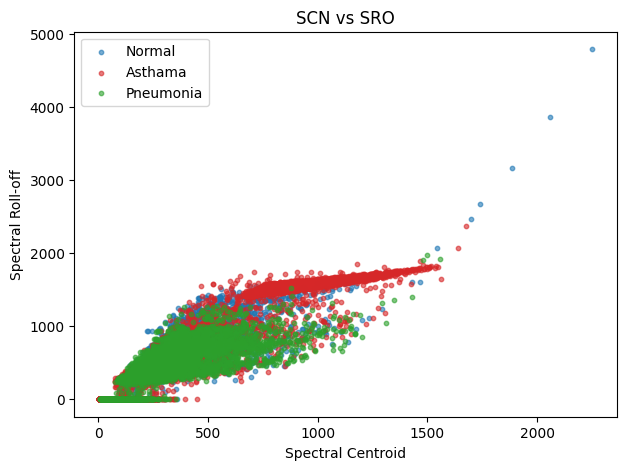

In [4]:
# Scatter: Spectral Centroid vs Spectral Flux
plt.figure(figsize=(7,5))
for cname, color in zip(CLASS_NAMES, ["#1f77b4","#d62728","#2ca02c"]):
    subset = df[df["Class"] == cname]
    plt.scatter(subset["SCN"], subset["SFLUX"], 
                s=10, alpha=0.6, label=cname, color=color)
plt.xlabel("Spectral Centroid")
plt.ylabel("Spectral Flux")
plt.title("SCN vs SFLUX")
plt.legend()
plt.show()

# Scatter: Spectral Centroid vs Spectral Roll-off
plt.figure(figsize=(7,5))
for cname, color in zip(CLASS_NAMES, ["#1f77b4","#d62728","#2ca02c"]):
    subset = df[df["Class"] == cname]
    plt.scatter(subset["SCN"], subset["SRO"], 
                s=10, alpha=0.6, label=cname, color=color)
plt.xlabel("Spectral Centroid")
plt.ylabel("Spectral Roll-off")
plt.title("SCN vs SRO")
plt.legend()
plt.show()


<div style="background: linear-gradient(135deg, #ff758c, #ff7eb3); 
            padding: 20px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.35);">

  <h2 style="margin-top:0; text-align:center; font-size:24px;">🔗 Feature Correlation Heatmaps</h2>

  <p style="font-size:15px; line-height:1.6;">
    Heatmaps give us a <b>visual overview</b> of how strongly different features are related.  
    Each cell shows a <b>correlation value</b> (from -1 to +1):  
  </p>

  <ul style="font-size:14px; line-height:1.6;">
    <li><b>+1 (red)</b> → features move together (highly redundant)</li>
    <li><b>-1 (blue)</b> → features move in opposite directions</li>
    <li><b>0 (neutral)</b> → no strong relationship (independent)</li>
  </ul>

  <hr style="border: 1px solid rgba(255,255,255,0.4);">

  <h3 style="margin-bottom:6px;">📌 What we plot</h3>
  <ul style="font-size:14px; line-height:1.6;">
    <li>📊 <b>All Classes Heatmap</b>: shows global correlations across the entire dataset</li>
    <li>🎯 <b>Per-Class Heatmaps</b>: reveal if relationships differ for 
        <span style="color:#FFD700;">Normal</span>, 
        <span style="color:#FF4500;">Asthama</span>, or 
        <span style="color:#ADFF2F;">Pneumonia</span></li>
  </ul>

  <p style="font-size:14px; line-height:1.6;">
    ✅ These heatmaps help us identify <b>redundant features</b> (high correlation) 
    and <b>complementary features</b> (low/negative correlation).  
    This is important for <b>feature selection</b> and reducing dimensionality before classification.
  </p>
</div>


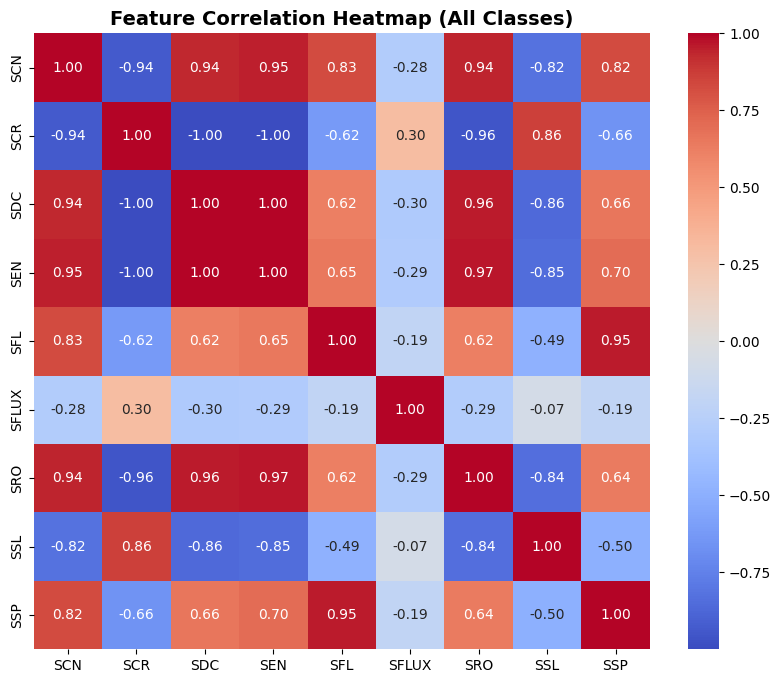

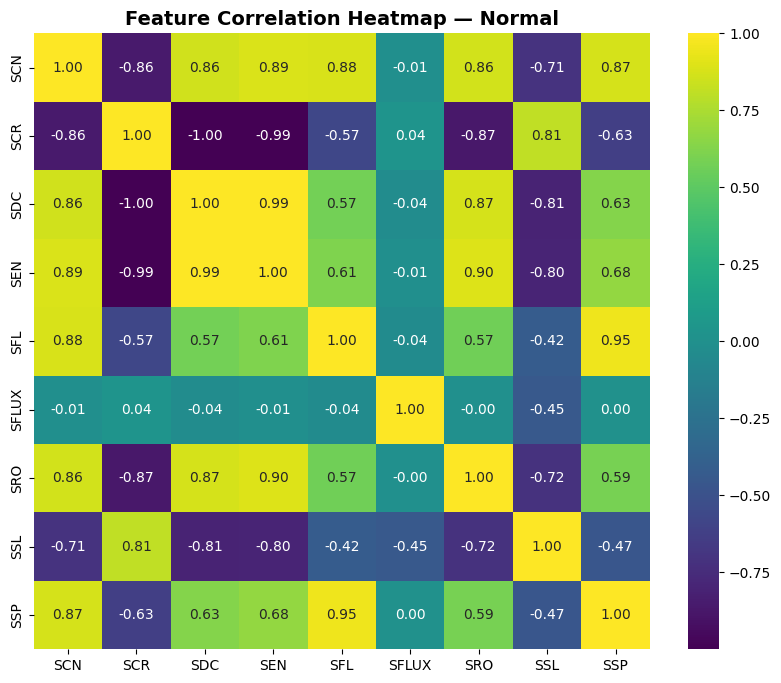

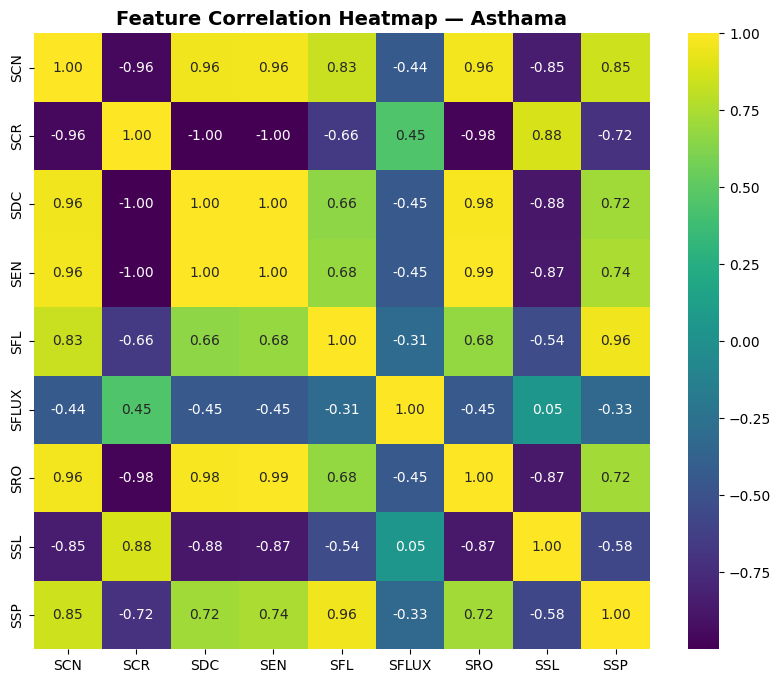

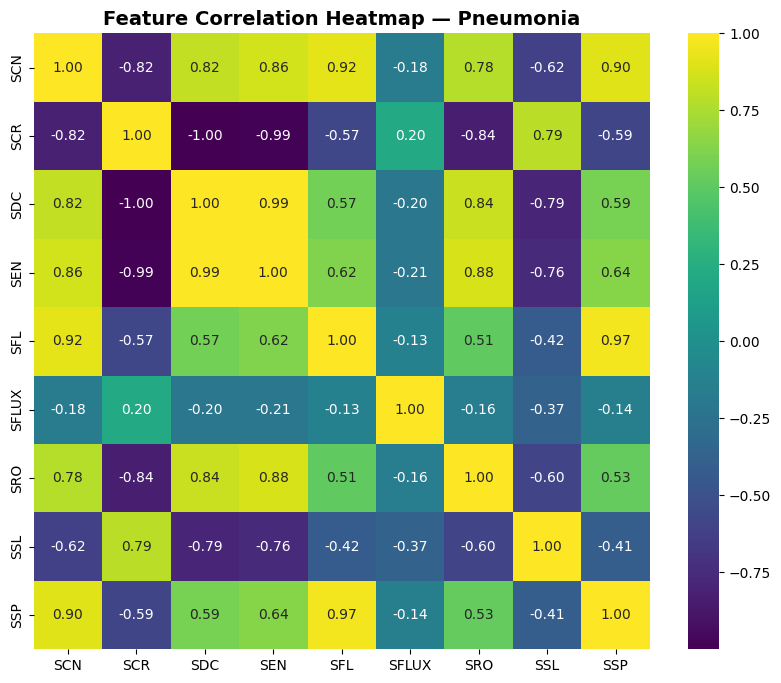

In [5]:
import seaborn as sns

# -----------------------------
# CORRELATION HEATMAP (all data)
# -----------------------------
plt.figure(figsize=(10,8))
corr = df.drop(columns=["Class","File"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Feature Correlation Heatmap (All Classes)", fontsize=14, weight="bold")
plt.show()

# -----------------------------
# CORRELATION HEATMAP PER CLASS
# -----------------------------
for cname in CLASS_NAMES:
    plt.figure(figsize=(10,8))
    subset = df[df["Class"] == cname].drop(columns=["Class","File"])
    corr = subset.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True)
    plt.title(f"Feature Correlation Heatmap — {cname}", fontsize=14, weight="bold")
    plt.show()


<div style="background: linear-gradient(135deg, #667eea, #764ba2); 
            padding: 24px; 
            border-radius: 14px; 
            color: #fff; 
            font-family: 'Segoe UI', sans-serif; 
            text-align:center; 
            box-shadow: 2px 2px 14px rgba(0,0,0,0.35);">

  <h2 style="margin-top:0; font-size:26px;">🌟 Notebook Completed!</h2>

  <p style="font-size:16px; line-height:1.6; max-width:800px; margin:auto;">
    In this notebook, we journeyed through the complete <b>Preprocessing and Feature Extraction Pipeline</b> 
    for lung sound analysis:
  </p>

  <ul style="text-align:left; display:inline-block; font-size:15px; line-height:1.7; margin-top:15px;">
    <li>✔️ Cleaned and normalized raw recordings</li>
    <li>✔️ Segmented signals into meaningful frames</li>
    <li>✔️ Removed silence and irrelevant parts</li>
    <li>✔️ Applied band-pass filtering (250–2000 Hz)</li>
    <li>✔️ Extracted 9 powerful spectral features</li>
    <li>✔️ Visualized relationships with scatter plots & heatmaps</li>
    <li>✔️ Saved features for machine learning experiments</li>
  </ul>

  <p style="font-size:15px; line-height:1.6; margin-top:20px;">
    🎯 You should now appreciate how <b>signal processing + feature engineering</b> 
    transforms raw biomedical audio into <b>meaningful data</b> for classification.  
    This foundation will guide us in the <b>next step: Machine Learning models</b> for detecting 
    <span style="color:#FFD700;">Asthma</span>, 
    <span style="color:#FF6347;">Pneumonia</span>, and 
    <span style="color:#ADFF2F;">Normal</span> cases.
  </p>

  <h3 style="margin-top:25px; font-size:20px;">🚀 Stay curious, experiment often, and keep learning!</h3>
</div>
